https://arxiv.org/pdf/2410.06375v1

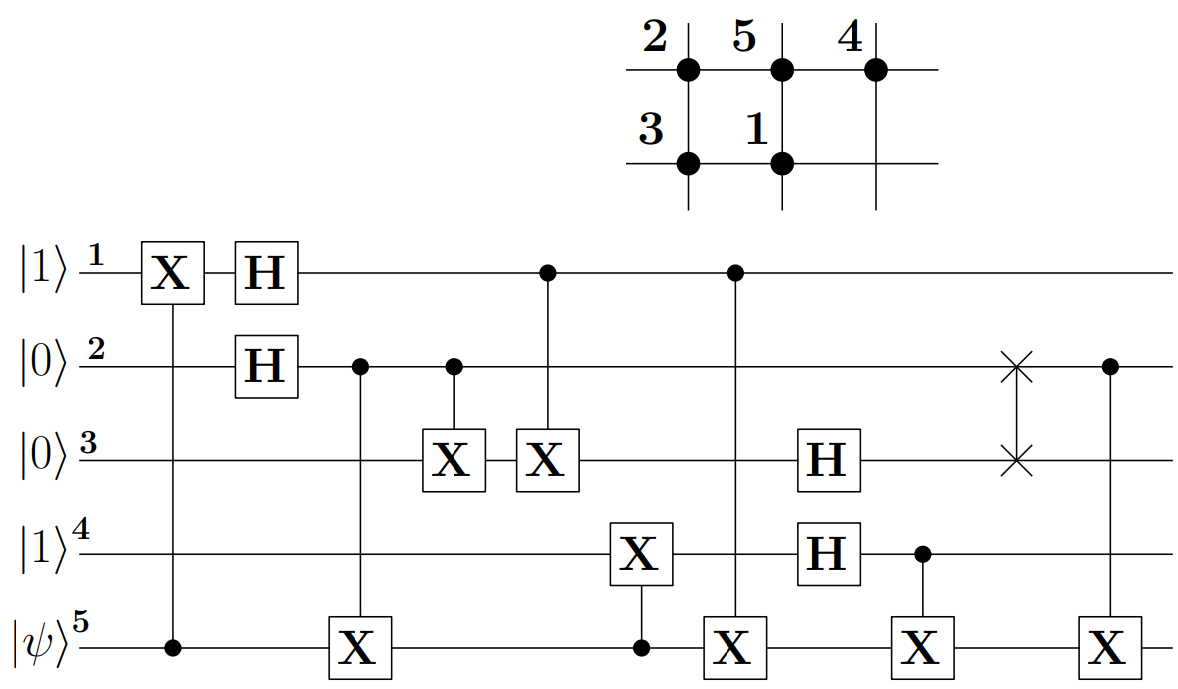

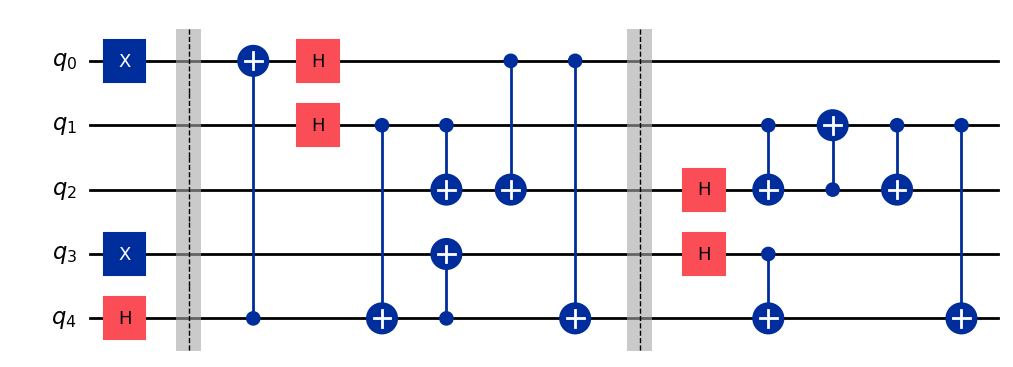

In [ ]:
import random
import numpy as np
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import Statevector, Pauli
from qiskit_aer.noise import pauli_error
def encoder_5q(x1, x2):
    qc = QuantumCircuit(5)
    if x1 == 0 and x2 == 1:
        qc.x(4)
    elif x1 == 1 and x2 == 0:
        qc.h(4)
    elif x1 == 1 and x2 == 1:
        qc.x(4)
        qc.h(4)

    qc.x(0)
    qc.x(3)
    qc.barrier()
    qc.cx(4, 0)
    qc.h(0)
    qc.h(1)
    qc.cx(1, 4)
    qc.cx(1, 2)
    qc.cx(0, 2)
    qc.cx(4, 3)
    qc.cx(0, 4)
    qc.barrier()
    qc.h(2)
    qc.h(3)
    qc.cx(3, 4)
    qc.cx(1, 2)
    qc.cx(2, 1)
    qc.cx(1, 2)
    qc.cx(1, 4)

    return qc

display(encoder_5q(1, 0).draw(output="mpl"))

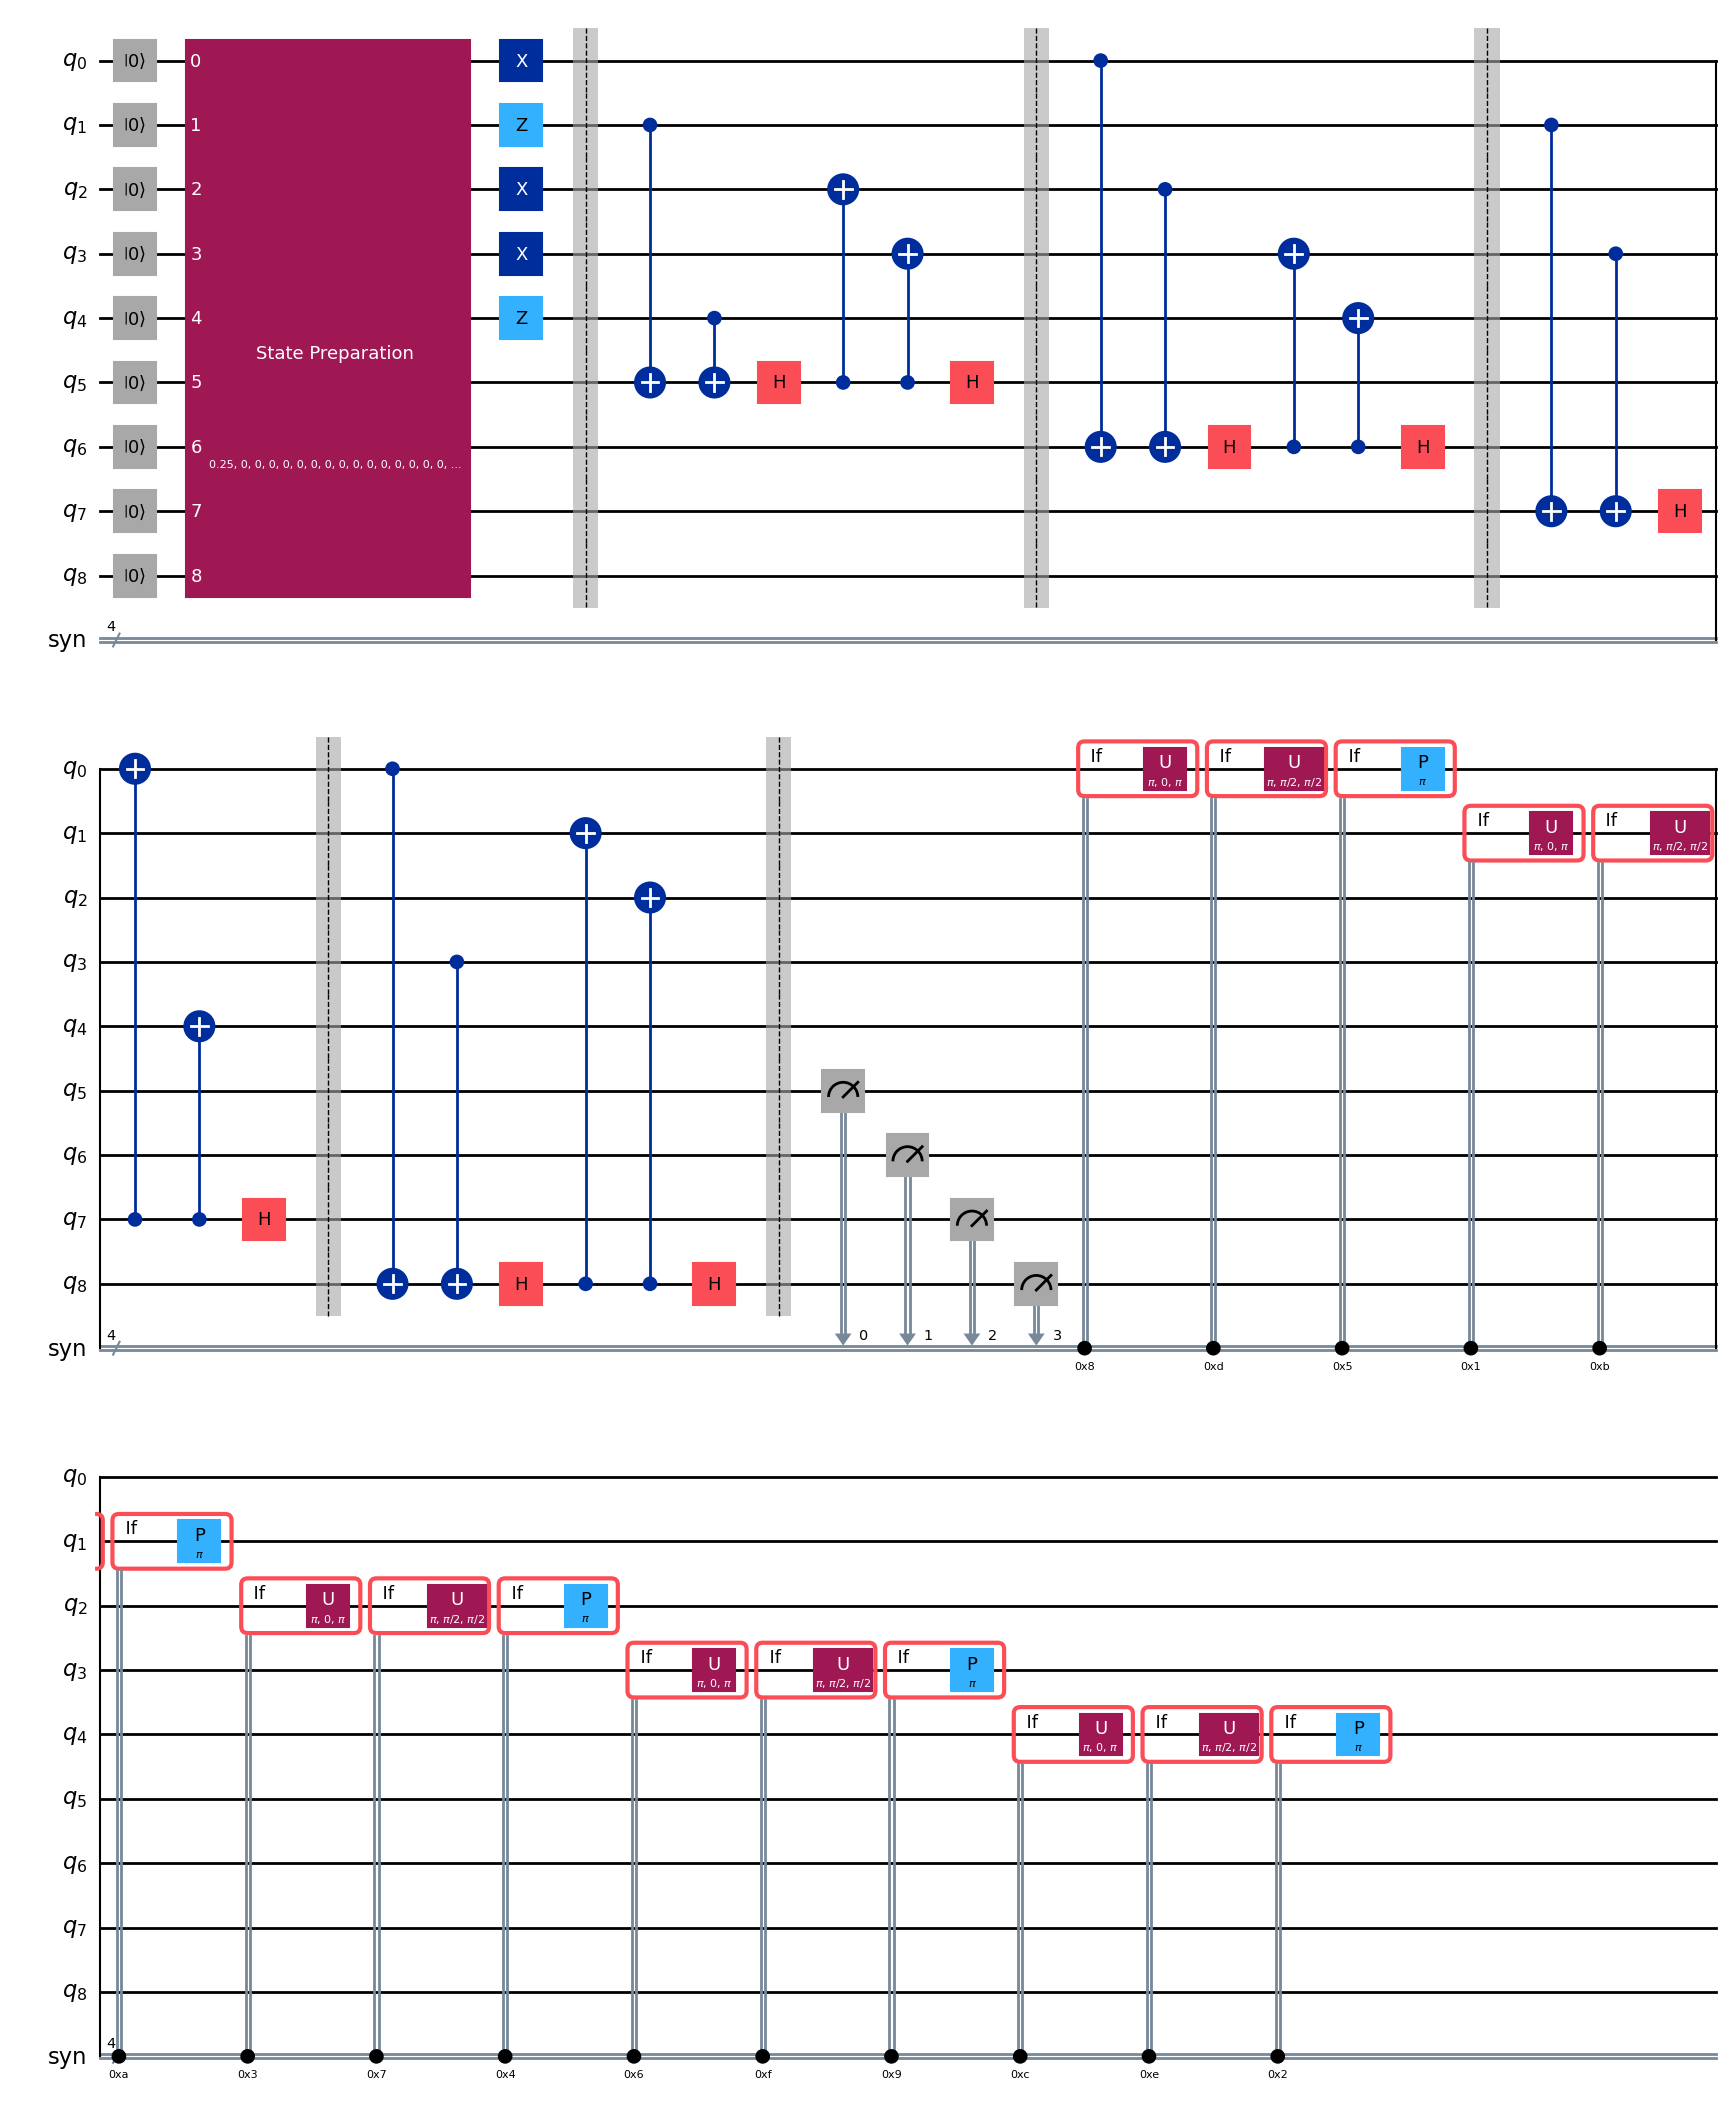

In [109]:
import random
import numpy as np
from qiskit import QuantumCircuit, transpile, ClassicalRegister
from qiskit.quantum_info import Statevector, Pauli
from qiskit_aer.noise import pauli_error

p = 0.3
# Stabilizers (cyclic form) and logical Z
G = ["IXZZX", "XIXZZ", "ZXIXZ", "XZZXI"]
ZL = Pauli("ZZZZZ")
XL = Pauli("XXXXX")
n = len(G[0])
k = n - len(G)

# Logical |0_L> for the [[5,1,3]] code
plus_terms  = ["00000","10010","01001","10100","01010","00101"]
minus_terms = ["11011","00110","11000","11101","00011","11110","01111","10001","01100","10111"]

syndrome_to_fix = {
    "0001": ("X", 0), "1011": ("Y", 0), "1010": ("Z", 0),
    "1000": ("X", 1), "1101": ("Y", 1), "0101": ("Z", 1),
    "1100": ("X", 2), "1110": ("Y", 2), "0010": ("Z", 2),
    "0110": ("X", 3), "1111": ("Y", 3), "1001": ("Z", 3),
    "0011": ("X", 4), "0111": ("Y", 4), "0100": ("Z", 4),
}

amps = np.zeros(32, dtype=complex)
for b in plus_terms:
    amps[int(b,2)] += 1/4
for b in minus_terms:
    amps[int(b,2)] -= 1/4

sv = Statevector(amps)
sv = sv.tensor(Statevector.from_label('0' * (n - k)))

def pauli_error_on_all_data_qubits(p) -> QuantumCircuit:
    qc = QuantumCircuit(n)
    for i in range(n):
        if random.random() < 3*p:
            error_type = random.choice(['X', 'Y', 'Z'])
            if error_type == 'X':
                qc.x(i)
            elif error_type == 'Y':
                qc.y(i)
            elif error_type == 'Z':
                qc.z(i)

    return qc

def measure_stabilizer(p_string) -> QuantumCircuit:
    
    x_indices = np.zeros(n, dtype=int)
    z_indices = np.zeros(n, dtype=int)
    qc = QuantumCircuit(n + 1, name=f"Measure {p_string}")

    for i, p in enumerate(p_string):
        if p == 'X':
            x_indices[i] = 1
        elif p == 'Z':
            z_indices[i] = 1

    for i in range(n):
        if x_indices[i] == 1:
            qc.cx(i, n)

    qc.h(n)
    for i in range(n):
        if z_indices[i] == 1:
            qc.cx(n, i)

    qc.h(n)

    return qc

qc_5q = QuantumCircuit(n + n - k)
qc_5q.initialize(sv.data, range(n + n - k))
qc_5q.append(pauli_error_on_all_data_qubits(p), range(n))


for i in range(n - k):
    qc_5q.barrier()
    qc_5q.append(measure_stabilizer(G[i]), list(range(n)) + [n + i])

qc_5q.barrier()
syn = ClassicalRegister(n - k, "syn")
qc_5q.add_register(syn)
qc_5q.measure(range(n, n + n - k), syn)

def apply_fix(pauli, q):
    if pauli == "X": qc_5q.x(q)
    elif pauli == "Z": qc_5q.z(q)
    else: qc_5q.y(q)

# add classical control blocks for each nonzero syndrome
for s, (pauli, q) in syndrome_to_fix.items():
    val = int(s[::-1], 2)              # syn[0] is LSB → reverse string
    with qc_5q.if_test((syn, val)):       # run when syn equals this syndrome
        apply_fix(pauli, q)

display(qc_5q.decompose().draw(output="mpl"))
# display(qc_5q.draw(output="mpl"))